## Implementation and Performance Analysis of Binary Frequency Shift Keying (BFSK) with Non-Coherent Detection Using Python

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from scipy.special import erfc
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

np.random.seed(42)
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['figure.figsize'] = (15, 8)

## System Parameters

In [17]:
f0 = 1000          # Carrier frequency for bit 0 (Hz)
f1 = 2000          # Carrier frequency for bit 1 (Hz)
fs = 10000         # Sampling frequency (Hz)
bit_duration = 0.01  # Duration of each bit (10 ms)
Es = 1.0           # Symbol energy

print('BFSK SYSTEM PARAMETERS')
print('='*50)
print(f'Carrier frequency f0 (bit 0): {f0} Hz')
print(f'Carrier frequency f1 (bit 1): {f1} Hz')
print(f'Frequency separation: {f1-f0} Hz')
print(f'Sampling frequency: {fs} Hz')
print(f'Bit duration: {bit_duration} s')
print(f'Samples per bit: {int(bit_duration*fs)}')
print(f'Symbol energy: {Es}')
print('='*50)

BFSK SYSTEM PARAMETERS
Carrier frequency f0 (bit 0): 1000 Hz
Carrier frequency f1 (bit 1): 2000 Hz
Frequency separation: 1000 Hz
Sampling frequency: 10000 Hz
Bit duration: 0.01 s
Samples per bit: 100
Symbol energy: 1.0


## 1. Input Signal Generation

This represents the **binary data** we want to transmit.

In [18]:
# Generate binary input signal
num_bits = 8
input_bits = np.array([0, 1, 0, 1, 1, 0, 1, 0])

print('INPUT BINARY SIGNAL')
print('='*50)
print(f'Number of bits: {num_bits}')
print(f'Binary sequence: {input_bits}')
print('='*50)

# Create time representation of input bits
samples_per_bit = int(bit_duration * fs)
input_signal_visual = np.repeat(input_bits, samples_per_bit)
t_bits = np.arange(len(input_signal_visual)) / fs

print(f'\nSignal duration: {num_bits * bit_duration} s')
print(f'Total samples: {len(input_signal_visual)}')

INPUT BINARY SIGNAL
Number of bits: 8
Binary sequence: [0 1 0 1 1 0 1 0]

Signal duration: 0.08 s
Total samples: 800


## 2. Carrier Signals

These are the **sinusoidal carriers** used to modulate the binary data.

In [19]:
# Generate carrier signals
T = 1 / fs  # Sampling period

# Time axis for first 3 bits
display_time = 3 * bit_duration
t_carrier = np.arange(int(display_time * fs)) * T

# Carrier signals
carrier_f0 = np.sqrt(2.0 * Es / samples_per_bit) * np.cos(2 * np.pi * f0 * t_carrier)
carrier_f1 = np.sqrt(2.0 * Es / samples_per_bit) * np.cos(2 * np.pi * f1 * t_carrier)

print('CARRIER SIGNALS')
print('=' * 50)
print(f'Carrier 0: f0 = {f0} Hz')
print(f'  Frequency: {f0} Hz')
print(f'  Period: {1/f0:.4f} s ({f0 * bit_duration} cycles)')
print(f'  Amplitude: {np.sqrt(2.0 * Es / samples_per_bit):.4f}')
print()
print(f'Carrier 1: f1 = {f1} Hz')
print(f'  Frequency: {f1} Hz')
print(f'  Period: {1/f1:.4f} s ({f1 * bit_duration} cycles)')
print(f'  Amplitude: {np.sqrt(2.0 * Es / samples_per_bit):.4f}')
print('=' * 50)

CARRIER SIGNALS
Carrier 0: f0 = 1000 Hz
  Frequency: 1000 Hz
  Period: 0.0010 s (10.0 cycles)
  Amplitude: 0.1414

Carrier 1: f1 = 2000 Hz
  Frequency: 2000 Hz
  Period: 0.0005 s (20.0 cycles)
  Amplitude: 0.1414


## 3. Input Signal and Carrier Visualization

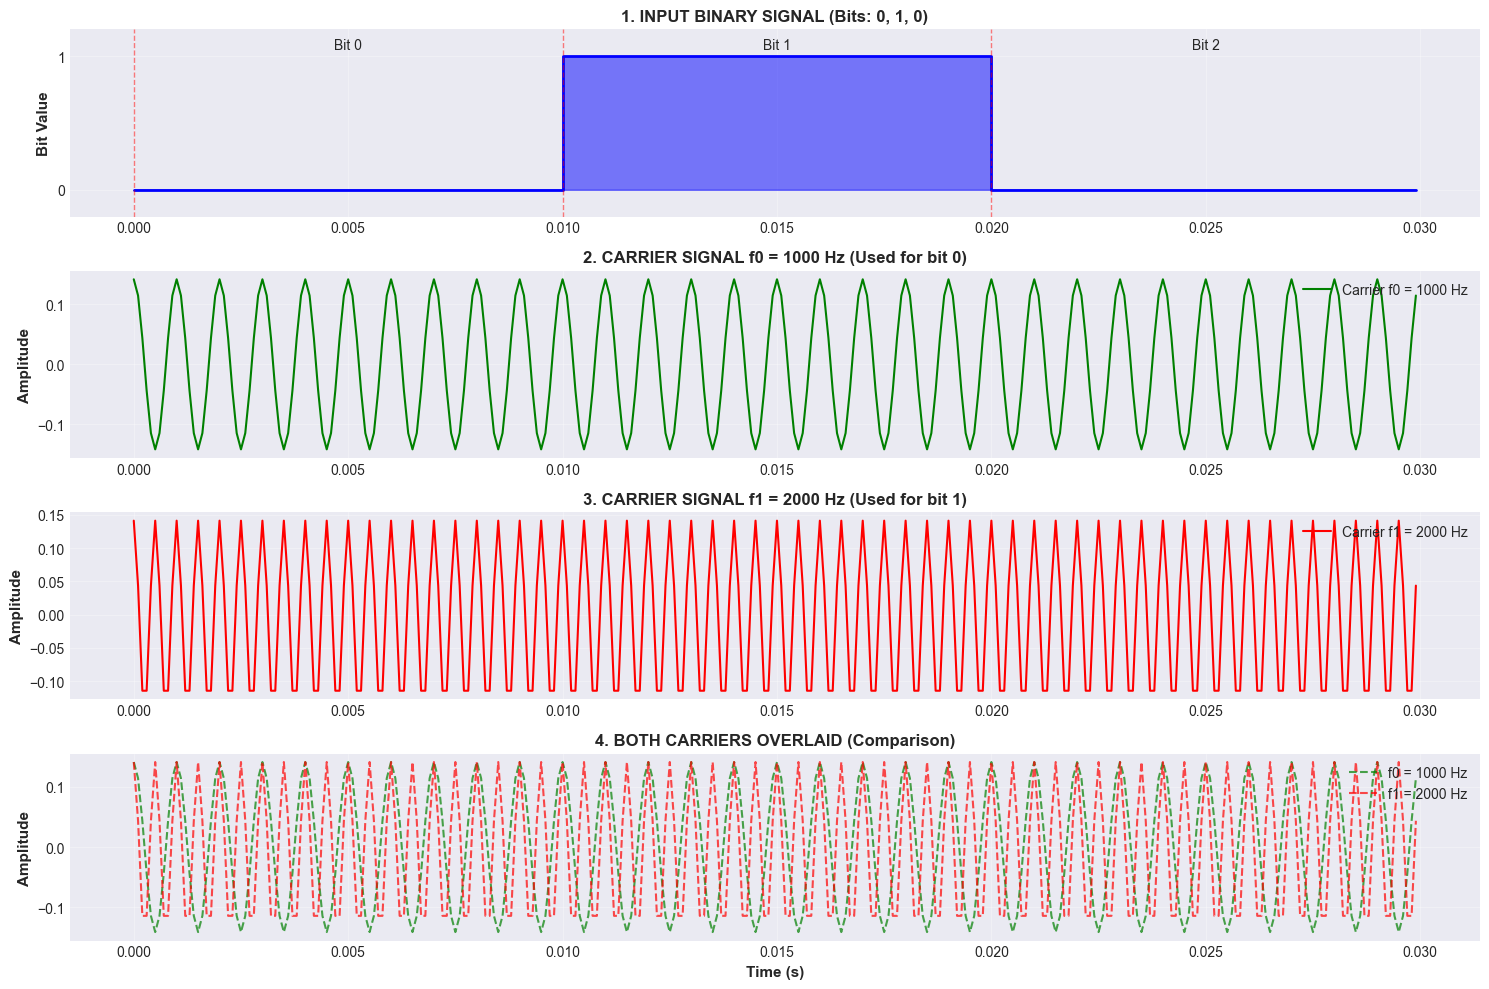

In [20]:
fig, axes = plt.subplots(4, 1, figsize=(15, 10))

# Plot 1: Input binary signal
display_time = 3 * bit_duration
display_samples = int(display_time * fs)
input_visual = input_signal_visual[:display_samples]
t_display = t_bits[:display_samples]

axes[0].fill_between(t_display, 0, input_visual, step='post', alpha=0.5, color='blue')
axes[0].plot(t_display, input_visual, 'b-', linewidth=2, drawstyle='steps-post')
axes[0].set_ylabel('Bit Value', fontsize=11, fontweight='bold')
axes[0].set_title('1. INPUT BINARY SIGNAL (Bits: 0, 1, 0)', fontsize=12, fontweight='bold')
axes[0].set_ylim([-0.2, 1.2])
axes[0].set_yticks([0, 1])
axes[0].grid(True, alpha=0.3)
for i in range(3):
    axes[0].axvline(x=i*bit_duration, color='red', linestyle='--', alpha=0.5, linewidth=1)
    axes[0].text(i*bit_duration + bit_duration/2, 1.05, 'Bit {}'.format(i), ha='center', fontsize=10)

# Plot 2: Carrier f0
axes[1].plot(t_carrier, carrier_f0, 'g-', linewidth=1.5, label='Carrier f0 = 1000 Hz')
axes[1].set_ylabel('Amplitude', fontsize=11, fontweight='bold')
axes[1].set_title('2. CARRIER SIGNAL f0 = 1000 Hz (Used for bit 0)', fontsize=12, fontweight='bold')
axes[1].grid(True, alpha=0.3)
axes[1].legend(loc='upper right', fontsize=10)

# Plot 3: Carrier f1
axes[2].plot(t_carrier, carrier_f1, 'r-', linewidth=1.5, label='Carrier f1 = 2000 Hz')
axes[2].set_ylabel('Amplitude', fontsize=11, fontweight='bold')
axes[2].set_title('3. CARRIER SIGNAL f1 = 2000 Hz (Used for bit 1)', fontsize=12, fontweight='bold')
axes[2].grid(True, alpha=0.3)
axes[2].legend(loc='upper right', fontsize=10)

# Plot 4: Both carriers overlaid
axes[3].plot(t_carrier, carrier_f0, 'g--', linewidth=1.5, alpha=0.7, label='f0 = 1000 Hz')
axes[3].plot(t_carrier, carrier_f1, 'r--', linewidth=1.5, alpha=0.7, label='f1 = 2000 Hz')
axes[3].set_xlabel('Time (s)', fontsize=11, fontweight='bold')
axes[3].set_ylabel('Amplitude', fontsize=11, fontweight='bold')
axes[3].set_title('4. BOTH CARRIERS OVERLAID (Comparison)', fontsize=12, fontweight='bold')
axes[3].grid(True, alpha=0.3)
axes[3].legend(loc='upper right', fontsize=10)

plt.tight_layout()
plt.show()

## 4. BFSK Modulation Process

**Modulation Rule:**
- If bit = 0: use carrier at f0 = 1000 Hz
- If bit = 1: use carrier at f1 = 2000 Hz

In [22]:
class BFSKModulator:
    def __init__(self, f0=1000, f1=2000, fs=10000, Es=1.0):
        self.f0 = f0
        self.f1 = f1
        self.fs = fs
        self.Es = Es
        self.T = 1 / fs
    
    def modulate(self, bits, bit_duration=0.01):
        samples_per_bit = int(bit_duration * self.fs)
        t_bit = np.arange(samples_per_bit) * self.T
        modulated = np.array([])
        
        for bit in bits:
            if bit == 1:
                f = self.f1
            else:
                f = self.f0
            
            # Modulated bit: amplitude-normalized cosine at frequency f
            signal_bit = np.sqrt(2.0 * self.Es / samples_per_bit) * np.cos(2 * np.pi * f * t_bit)
            modulated = np.concatenate([modulated, signal_bit])
        
        t_total = np.arange(len(modulated)) * self.T
        return modulated, t_total
    
    def add_awgn(self, signal_data, snr_db):
        snr_linear = 10 ** (snr_db / 10)
        N0 = self.Es / snr_linear
        noise_std = np.sqrt(N0 / 2.0)
        noise = np.random.normal(0, noise_std, len(signal_data))
        return signal_data + noise


In [23]:
class BFSKDemodulator:
    def __init__(self, f0=1000, f1=2000, fs=10000):
        self.f0 = f0
        self.f1 = f1
        self.fs = fs
        self.T = 1 / fs
    
    def coherent_detection(self, received_signal, bit_duration=0.01):
        samples_per_bit = int(bit_duration * self.fs)
        num_bits = len(received_signal) // samples_per_bit
        decoded_bits = []
        
        t_bit = np.arange(samples_per_bit) * self.T
        ref_0 = np.sqrt(2.0) * np.cos(2 * np.pi * self.f0 * t_bit)
        ref_1 = np.sqrt(2.0) * np.cos(2 * np.pi * self.f1 * t_bit)
        
        for i in range(num_bits):
            start = i * samples_per_bit
            end = start + samples_per_bit
            bit_signal = received_signal[start:end]
            
            # Correlation with ref_0
            corr_0 = np.sum(bit_signal * ref_0)
            # Correlation with ref_1
            corr_1 = np.sum(bit_signal * ref_1)
            
            # Decide: which correlation is larger?
            if corr_1 > corr_0:
                decoded_bits.append(1)
            else:
                decoded_bits.append(0)
        
        return np.array(decoded_bits, dtype=int)
    
    def non_coherent_detection(self, received_signal, bit_duration=0.01):
        samples_per_bit = int(bit_duration * self.fs)
        num_bits = len(received_signal) // samples_per_bit
        decoded_bits = []
        
        f_low0, f_high0 = max(10, self.f0 - 400), min(self.fs/2 - 10, self.f0 + 400)
        f_low1, f_high1 = max(10, self.f1 - 400), min(self.fs/2 - 10, self.f1 + 400)
        
        try:
            sos_0 = signal.butter(3, [f_low0, f_high0], 'bp', fs=self.fs, output='sos')
            sos_1 = signal.butter(3, [f_low1, f_high1], 'bp', fs=self.fs, output='sos')
            
            filtered_0 = signal.sosfilt(sos_0, received_signal)
            filtered_1 = signal.sosfilt(sos_1, received_signal)
            
            envelope_0 = np.abs(signal.hilbert(filtered_0))
            envelope_1 = np.abs(signal.hilbert(filtered_1))
        except:
            return self.coherent_detection(received_signal, bit_duration)
        
        for i in range(num_bits):
            start = i * samples_per_bit
            end = start + samples_per_bit
            
            avg_0 = np.mean(envelope_0[start:end])
            avg_1 = np.mean(envelope_1[start:end])
            
            decoded_bits.append(1 if avg_1 > avg_0 else 0)
        
        return np.array(decoded_bits, dtype=int)

## 5. Modulation Demonstration

In [24]:
modulator = BFSKModulator(f0=f0, f1=f1, fs=fs, Es=Es)
modulated_signal, t_mod = modulator.modulate(input_bits, bit_duration)

print('BFSK MODULATION APPLIED')
print('=' * 60)
print(f'Input bits: {input_bits}')
print(f'Modulated signal length: {len(modulated_signal)} samples')
print(f'Modulated signal duration: {num_bits * bit_duration:.3f} s')
print('=' * 60)

print('\nModulation mapping:')
for i, bit in enumerate(input_bits):
    freq = f1 if bit == 1 else f0
    print(f'  Bit {i}: {bit} -> f = {freq} Hz')

BFSK MODULATION APPLIED
Input bits: [0 1 0 1 1 0 1 0]
Modulated signal length: 800 samples
Modulated signal duration: 0.080 s

Modulation mapping:
  Bit 0: 0 -> f = 1000 Hz
  Bit 1: 1 -> f = 2000 Hz
  Bit 2: 0 -> f = 1000 Hz
  Bit 3: 1 -> f = 2000 Hz
  Bit 4: 1 -> f = 2000 Hz
  Bit 5: 0 -> f = 1000 Hz
  Bit 6: 1 -> f = 2000 Hz
  Bit 7: 0 -> f = 1000 Hz


## 6. Modulated Signal Visualization

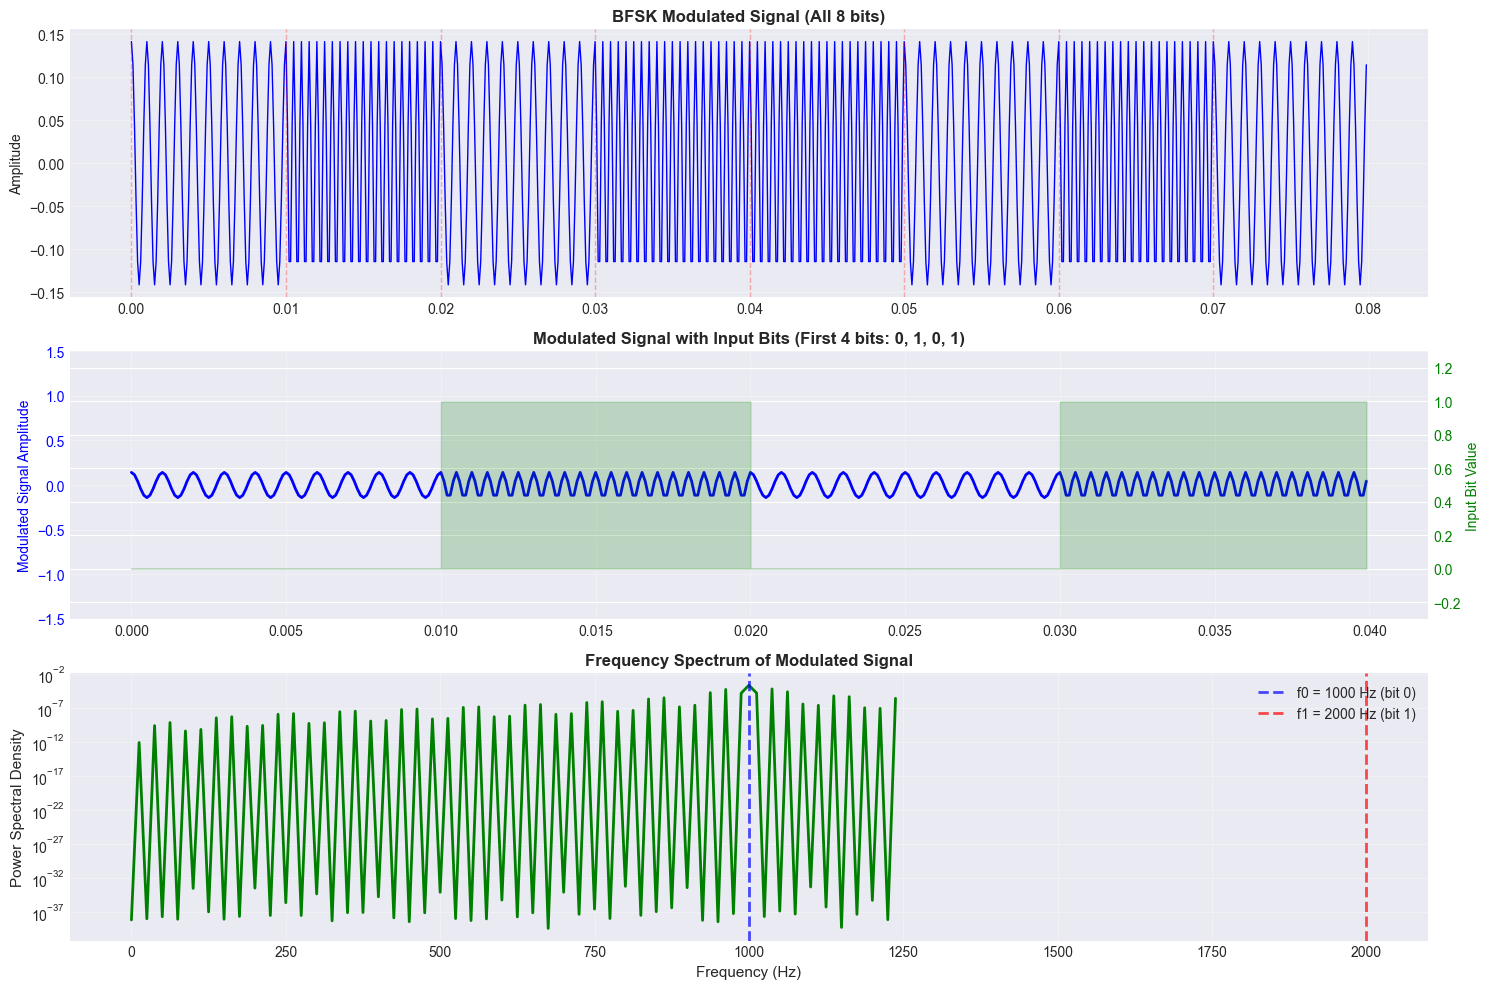

In [25]:
fig, axes = plt.subplots(3, 1, figsize=(15, 10))

# Plot 1: Full modulated signal (all 8 bits)
axes[0].plot(t_mod, modulated_signal, 'b-', linewidth=1)
axes[0].set_title('BFSK Modulated Signal (All 8 bits)', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Amplitude')
axes[0].grid(True, alpha=0.3)
for i in range(num_bits):
    axes[0].axvline(x=i*bit_duration, color='red', linestyle='--', alpha=0.3, linewidth=1)

# Plot 2: First 4 bits with input bits overlaid
display_bits = 4
display_samples = int(display_bits * bit_duration * fs)
input_viz = np.repeat(input_bits[:display_bits], samples_per_bit)

ax2a = axes[1]
ax2b = ax2a.twinx()

ax2a.plot(t_mod[:display_samples], modulated_signal[:display_samples], 'b-', linewidth=2, label='Modulated signal')
ax2b.fill_between(t_bits[:display_samples], 0, input_viz, step='post', alpha=0.2, color='green', label='Input bits')

ax2a.set_title('Modulated Signal with Input Bits (First 4 bits: 0, 1, 0, 1)', fontsize=12, fontweight='bold')
ax2a.set_ylabel('Modulated Signal Amplitude', fontsize=10, color='blue')
ax2b.set_ylabel('Input Bit Value', fontsize=10, color='green')
ax2a.tick_params(axis='y', labelcolor='blue')
ax2b.tick_params(axis='y', labelcolor='green')
ax2a.grid(True, alpha=0.3)
ax2a.set_ylim([-1.5, 1.5])
ax2b.set_ylim([-0.3, 1.3])

# Plot 3: Frequency spectrum
freq, Pxx = signal.periodogram(modulated_signal, fs=fs)
axes[2].semilogy(freq[:len(freq)//4], Pxx[:len(Pxx)//4], 'g-', linewidth=2)
axes[2].axvline(x=f0, color='blue', linestyle='--', linewidth=2, label='f0 = 1000 Hz (bit 0)', alpha=0.7)
axes[2].axvline(x=f1, color='red', linestyle='--', linewidth=2, label='f1 = 2000 Hz (bit 1)', alpha=0.7)
axes[2].set_title('Frequency Spectrum of Modulated Signal', fontsize=12, fontweight='bold')
axes[2].set_xlabel('Frequency (Hz)', fontsize=11)
axes[2].set_ylabel('Power Spectral Density', fontsize=11)
axes[2].legend(loc='upper right', fontsize=10)
axes[2].grid(True, alpha=0.3, which='both')

plt.tight_layout()
plt.show()


## 7. Demodulation and Detection

In [26]:
demodulator = BFSKDemodulator(f0=f0, f1=f1, fs=fs)

# At different SNR levels
snr_test = [20, 10, 5, 0]

print('DEMODULATION TEST AT DIFFERENT SNR LEVELS')
print('='*70)

for snr_val in snr_test:
    rx_signal = modulator.add_awgn(modulated_signal, snr_val)
    
    decoded_coh = demodulator.coherent_detection(rx_signal, bit_duration)
    decoded_nc = demodulator.non_coherent_detection(rx_signal, bit_duration)
    
    errors_coh = np.sum(input_bits != decoded_coh)
    errors_nc = np.sum(input_bits != decoded_nc)
    
    print('\nSNR = {} dB:'.format(snr_val))
    print('  Input (Tx):           {}'.format(input_bits))
    print('  Coherent (Rx):        {} | Errors: {}'.format(decoded_coh, errors_coh))
    print('  Non-Coherent (Rx):    {} | Errors: {}'.format(decoded_nc, errors_nc))

print('\n' + '='*70)

DEMODULATION TEST AT DIFFERENT SNR LEVELS

SNR = 20 dB:
  Input (Tx):           [0 1 0 1 1 0 1 0]
  Coherent (Rx):        [0 1 0 1 1 0 1 0] | Errors: 0
  Non-Coherent (Rx):    [0 1 0 1 1 0 1 0] | Errors: 0

SNR = 10 dB:
  Input (Tx):           [0 1 0 1 1 0 1 0]
  Coherent (Rx):        [0 1 0 1 1 0 1 0] | Errors: 0
  Non-Coherent (Rx):    [0 1 0 1 1 0 1 0] | Errors: 0

SNR = 5 dB:
  Input (Tx):           [0 1 0 1 1 0 1 0]
  Coherent (Rx):        [0 1 0 1 1 0 1 1] | Errors: 1
  Non-Coherent (Rx):    [0 1 0 0 0 0 1 1] | Errors: 3

SNR = 0 dB:
  Input (Tx):           [0 1 0 1 1 0 1 0]
  Coherent (Rx):        [1 1 0 1 1 1 1 0] | Errors: 2
  Non-Coherent (Rx):    [1 1 0 1 0 0 1 0] | Errors: 2



## 8. Received Signals at Different SNR Levels

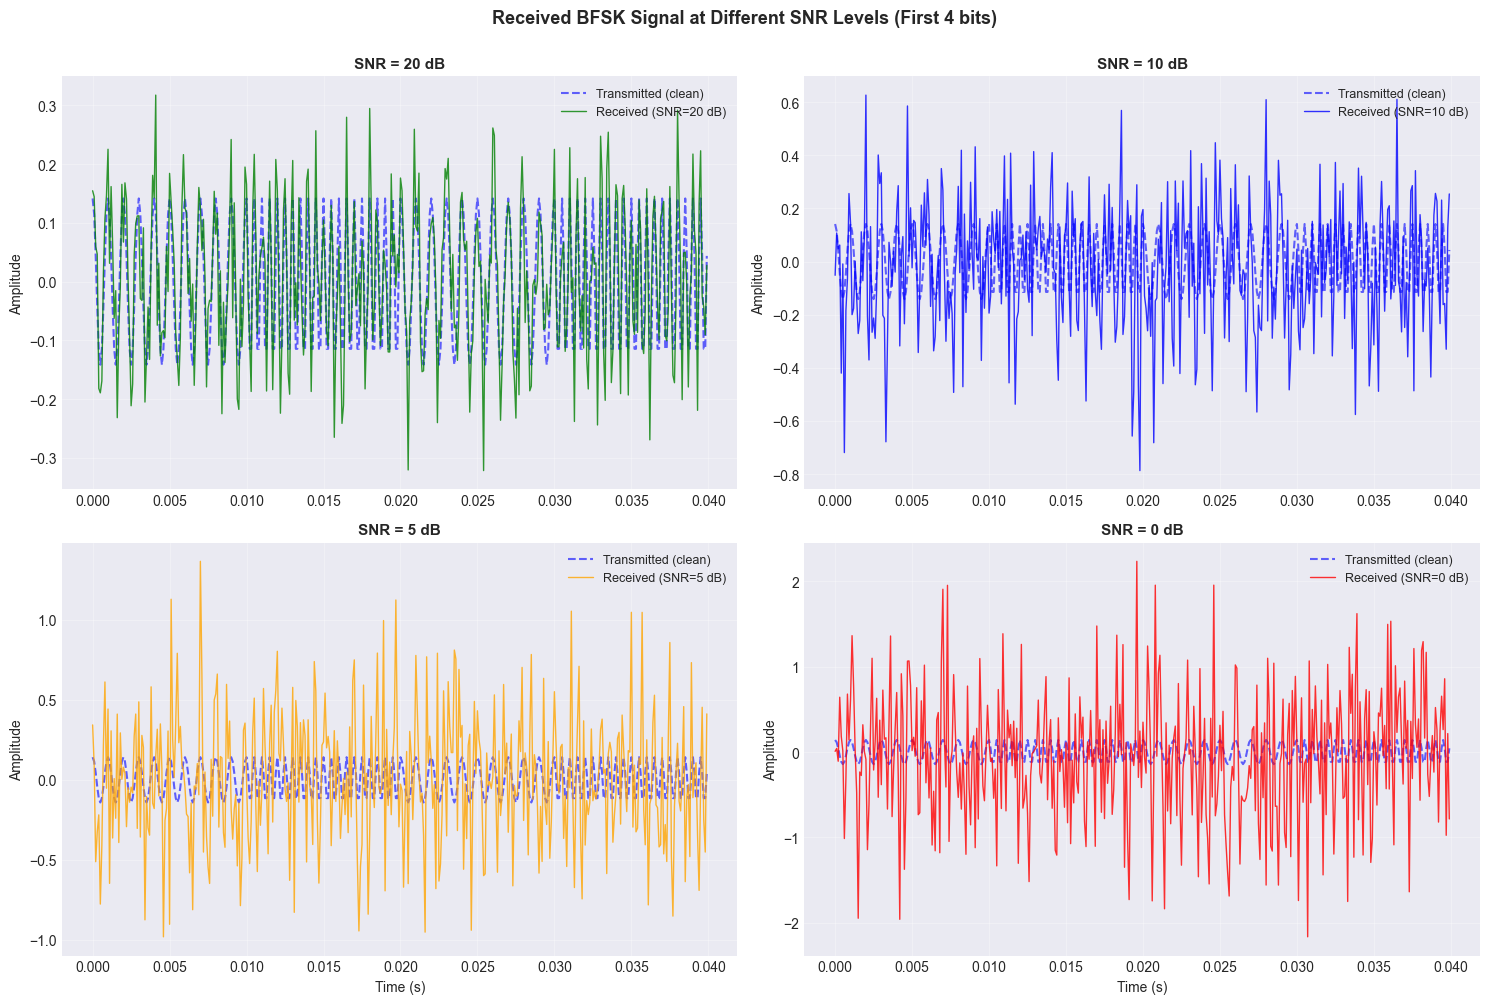

In [27]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.flatten()

snr_levels = [20, 10, 5, 0]
colors = ['green', 'blue', 'orange', 'red']

display_bits = 4
display_samples = int(display_bits * bit_duration * fs)

for idx, (snr, color) in enumerate(zip(snr_levels, colors)):
    rx = modulator.add_awgn(modulated_signal, snr)
    
    axes[idx].plot(t_mod[:display_samples], modulated_signal[:display_samples], 'b--', 
                   linewidth=1.5, alpha=0.6, label='Transmitted (clean)')
    axes[idx].plot(t_mod[:display_samples], rx[:display_samples], color=color, 
                   linewidth=1, alpha=0.8, label='Received (SNR={} dB)'.format(snr))
    
    axes[idx].set_title('SNR = {} dB'.format(snr), fontsize=11, fontweight='bold')
    axes[idx].set_ylabel('Amplitude')
    axes[idx].grid(True, alpha=0.3)
    axes[idx].legend(loc='upper right', fontsize=9)
    
    if idx >= 2:
        axes[idx].set_xlabel('Time (s)')

plt.suptitle('Received BFSK Signal at Different SNR Levels (First 4 bits)', fontsize=13, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()


## 9. Complete BER vs SNR Analysis

In [12]:
print('Starting BER analysis (this takes 5-7 minutes)...')
print('Testing 100,000 bits per SNR point\n')

snr_range = np.arange(-2, 16, 1)
num_trials = 50
bits_per_trial = 2000

ber_coherent = []
ber_non_coherent = []
ber_theoretical = []

for snr_val in snr_range:
    print('SNR = {} dB'.format(snr_val))
    
    errors_coh = 0
    errors_nc = 0
    
    for trial in range(num_trials):
        tx_bits = np.random.randint(0, 2, bits_per_trial)
        tx_sig, _ = modulator.modulate(tx_bits, bit_duration)
        rx_sig = modulator.add_awgn(tx_sig, snr_val)
        
        rx_coh = demodulator.coherent_detection(rx_sig, bit_duration)
        errors_coh += np.sum(tx_bits != rx_coh)
        
        rx_nc = demodulator.non_coherent_detection(rx_sig, bit_duration)
        errors_nc += np.sum(tx_bits != rx_nc)
    
    total_bits = num_trials * bits_per_trial
    ber_coherent.append(errors_coh / total_bits)
    ber_non_coherent.append(errors_nc / total_bits)
    
    snr_lin = 10 ** (snr_val / 10)
    ber_theo = 0.5 * erfc(np.sqrt(snr_lin / 2))
    ber_theoretical.append(ber_theo)
    
    print('  Coh: {:.6f} | NC: {:.6f} | Theory: {:.6f}'.format(
        ber_coherent[-1], ber_non_coherent[-1], ber_theo))

ber_coherent = np.array(ber_coherent)
ber_non_coherent = np.array(ber_non_coherent)
ber_theoretical = np.array(ber_theoretical)

print('\nAnalysis complete!')

Starting BER analysis (this takes 5-7 minutes)...
Testing 100,000 bits per SNR point

SNR = -2 dB
  Coh: 0.212860 | NC: 0.443090 | Theory: 0.213502
SNR = -1 dB
  Coh: 0.186460 | NC: 0.425340 | Theory: 0.186397
SNR = 0 dB
  Coh: 0.159010 | NC: 0.409500 | Theory: 0.158655
SNR = 1 dB
  Coh: 0.132730 | NC: 0.388170 | Theory: 0.130927
SNR = 2 dB
  Coh: 0.104920 | NC: 0.362810 | Theory: 0.104029
SNR = 3 dB
  Coh: 0.078810 | NC: 0.327310 | Theory: 0.078896
SNR = 4 dB
  Coh: 0.055780 | NC: 0.293060 | Theory: 0.056495
SNR = 5 dB
  Coh: 0.037440 | NC: 0.254080 | Theory: 0.037679
SNR = 6 dB
  Coh: 0.022300 | NC: 0.207410 | Theory: 0.023007
SNR = 7 dB
  Coh: 0.012250 | NC: 0.160580 | Theory: 0.012587
SNR = 8 dB
  Coh: 0.006380 | NC: 0.114700 | Theory: 0.006004
SNR = 9 dB
  Coh: 0.002290 | NC: 0.073340 | Theory: 0.002413
SNR = 10 dB
  Coh: 0.000890 | NC: 0.042530 | Theory: 0.000783
SNR = 11 dB
  Coh: 0.000150 | NC: 0.019440 | Theory: 0.000194
SNR = 12 dB
  Coh: 0.000020 | NC: 0.007370 | Theory: 0.0

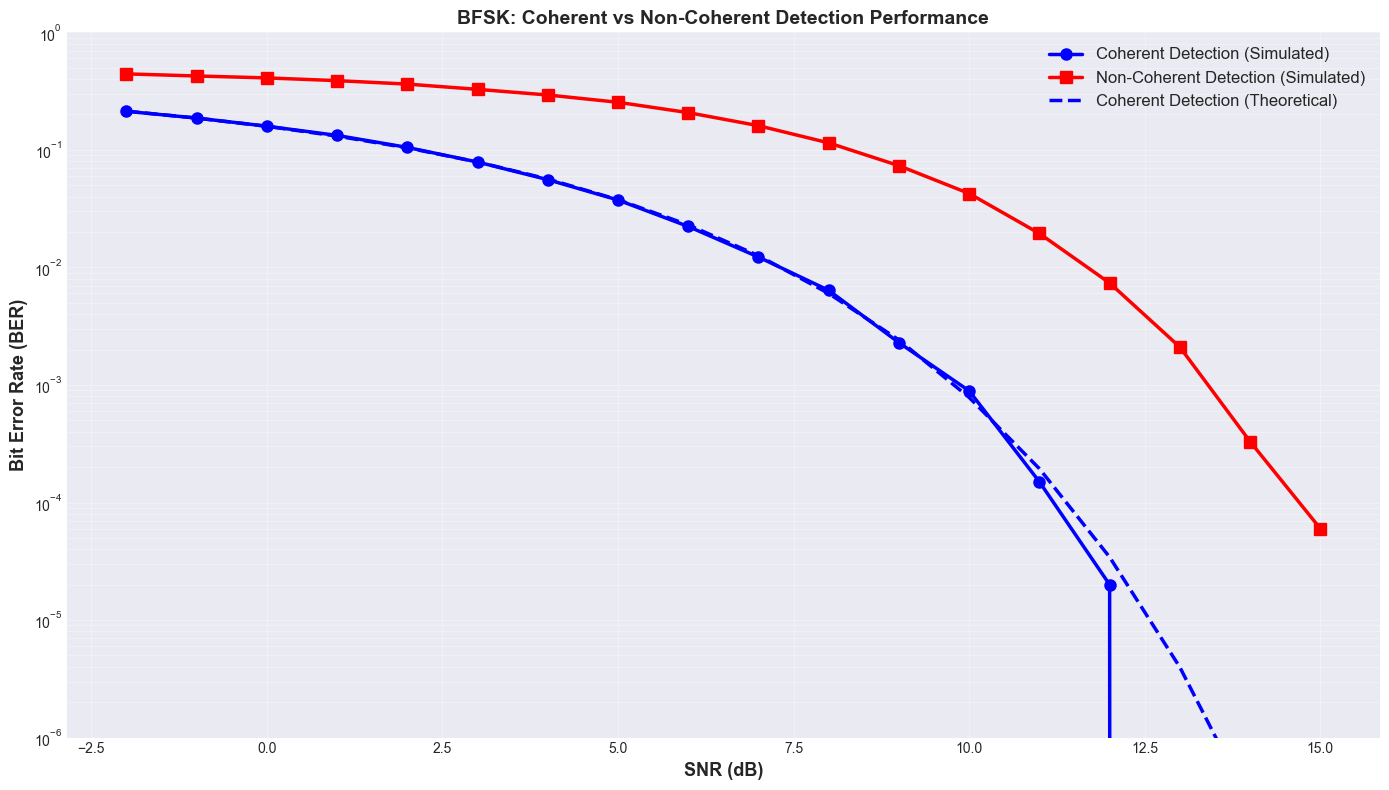

In [28]:
fig, ax = plt.subplots(figsize=(14, 8))

ax.semilogy(snr_range, ber_coherent, 'o-', color='blue', linewidth=2.5, markersize=8, 
            label='Coherent Detection (Simulated)', zorder=3)
ax.semilogy(snr_range, ber_non_coherent, 's-', color='red', linewidth=2.5, markersize=8, 
            label='Non-Coherent Detection (Simulated)', zorder=3)
ax.semilogy(snr_range, ber_theoretical, '--', color='blue', linewidth=2.5, 
            label='Coherent Detection (Theoretical)', zorder=2)

ax.set_xlabel('SNR (dB)', fontsize=13, fontweight='bold')
ax.set_ylabel('Bit Error Rate (BER)', fontsize=13, fontweight='bold')
ax.set_title('BFSK: Coherent vs Non-Coherent Detection Performance', fontsize=14, fontweight='bold')
ax.grid(True, which='both', alpha=0.3)
ax.legend(fontsize=12, loc='upper right')
ax.set_ylim([1e-6, 1])

plt.tight_layout()
plt.show()



In [14]:
df = pd.DataFrame({
    'SNR (dB)': snr_range.astype(int),
    'Coherent BER': ber_coherent,
    'Non-Coherent BER': ber_non_coherent,
    'Theoretical': ber_theoretical
})

print('\n' + '='*100)
print('BER RESULTS TABLE')
print('='*100)
print(df.to_string(index=False))
print('='*100)


BER RESULTS TABLE
 SNR (dB)  Coherent BER  Non-Coherent BER  Theoretical
       -2       0.21286           0.44309 2.135022e-01
       -1       0.18646           0.42534 1.863973e-01
        0       0.15901           0.40950 1.586553e-01
        1       0.13273           0.38817 1.309273e-01
        2       0.10492           0.36281 1.040286e-01
        3       0.07881           0.32731 7.889587e-02
        4       0.05578           0.29306 5.649530e-02
        5       0.03744           0.25408 3.767899e-02
        6       0.02230           0.20741 2.300714e-02
        7       0.01225           0.16058 1.258703e-02
        8       0.00638           0.11470 6.004386e-03
        9       0.00229           0.07334 2.413310e-03
       10       0.00089           0.04253 7.827011e-04
       11       0.00015           0.01944 1.939855e-04
       12       0.00002           0.00737 3.430262e-05
       13       0.00000           0.00210 3.969248e-06
       14       0.00000           0.00033 2.69

## Real Life Application with Different SNR values

In [ ]:
def text_to_bits(text):
    bits = bin(int.from_bytes(text.encode(), 'big'))[2:]
    bits = bits.zfill(8 * ((len(bits) + 7) // 8))
    return np.array([int(b) for b in bits])

def bits_to_text(bits):
    try:
        chars = []
        for b in range(len(bits) // 8):
            byte = bits[b*8:(b+1)*8]
            chars.append(chr(int(''.join(map(str, byte)), 2)))
        return "".join(chars)
    except:
        return "[Decoding Error]"


fs_sim = 20000
f0_sim = 2000
f1_sim = 4000
mod_text = BFSKModulator(f0=f0_sim, f1=f1_sim, fs=fs_sim)
demod_text = BFSKDemodulator(f0=f0_sim, f1=f1_sim, fs=fs_sim)

original_message = "My name is Jahirul Islam."
tx_bits = text_to_bits(original_message)

print(f"Original Message: '{original_message}'")
print(f"Transmitted Bits: {len(tx_bits)} bits")
print("-" * 60)


snr_levels = [75, 20, 0, -5] # dB

for snr in snr_levels:
    
    sig, t = mod_text.modulate(tx_bits, bit_duration=0.002)

    noisy_sig = mod_text.add_awgn(sig, snr)

    rx_bits = demod_text.non_coherent_detection(noisy_sig, bit_duration=0.002)

    rx_bits_trimmed = rx_bits[:len(tx_bits)]
    decoded_text = bits_to_text(rx_bits_trimmed)

    bit_errors = np.sum(np.abs(tx_bits - rx_bits_trimmed))

    print(f"SNR = {snr:>3} dB | Errors: {bit_errors:>3} | Received: '{decoded_text}'")

print("-" * 60)
print("Observation: As SNR decreases (more noise), characters start to change or disappear.")


Original Message: 'My name is Jahirul Islam.'
Transmitted Bits: 200 bits
------------------------------------------------------------
SNR =  75 dB | Errors:   0 | Received: 'My name is Jahirul Islam.'
SNR =  20 dB | Errors:   9 | Received: 'Gy oame iq0Hahmrun Islam.'
SNR =   0 dB | Errors:  82 | Received: 'Gª¨¼55l`Dx	&a@yî_l.ö"'
SNR =  -5 dB | Errors:  90 | Received: 'ÉñìugySùpðºc©õ&n)ÝTy'
------------------------------------------------------------
Observation: As SNR decreases (more noise), characters start to change or disappear.
